#Mount drive, Import, Install

In [ ]:
!pip install tensorflow-addons==0.16.1

In [ ]:
from google.colab import drive  #add it in github and access from there like in tutorial
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from zipfile import ZipFile
import pandas as pd
import os, time
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random

In [ ]:
#Set seed value
seed_value = 43

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

#numpy seed
np.random.seed(seed_value)

#Tf seed
tf.random.set_seed(seed_value)

#Configure new global tensorflow session
from tensorflow.compat.v1.keras import backend as k
session_conf = tf.compat.v1.ConfigProto (
    intra_op_parallelism_threads = 1,
    inter_op_parallelism_threads = 1
)

sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = session_conf)
k.set_session(sess)

#Dataset creation

In [ ]:
!unzip /content/drive/Shareddrives/DeepLearning_VisionAnalytics/Dataset/archive.zip > logs.txt

In [ ]:
#Hyper params
split = 0.8
height, width = 240, 320

In [ ]:
train_df = pd.read_csv('/content/nyu_data/data/nyu2_train.csv',header=None)
test = pd.read_csv('/content/nyu_data/data/nyu2_test.csv',header=None).rename(columns={0:'image', 1:'depth'})
train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
train_split = int(len(train_df)*split)

train = train_df[:train_split]
validation = train_df[train_split:]
len(train), len(validation)

(40550, 10138)

#Classes and functions

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, dataframe, batch_size, shuffle=False, dim=(320,240)):
    # for reproducibility
    np.random.seed(43)
    # dataframe containing the subset of image and depth pairs
    self.df = dataframe
    # chosen Height and Width of the RGB image
    self.height, self.width = dim
    # choice of shuffling the data
    self.shuffle = shuffle
    self.batch_size = batch_size
    # unique set of RGB images
    self.ids = dataframe['image'].unique()
    # Map the image with depth maps
    self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
    self.on_epoch_end()

  def __len__(self):
    '''
    Returns the length of dataset.
    '''
    return len(self.df) // self.batch_size

  def on_epoch_end(self):
    '''
    Shuffles the data at the end of every epoch
    '''
    self.indexes = np.arange(len(self.ids))
    if self.shuffle:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self,index):
    '''
    returns the batch of image and depth pairs 
    '''
    # select the batch of pair indexes 
    idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
    # randomly select whether to flip the image
    flip = np.random.choice([True, False])
    # select the image id's for the above indexes
    query_imgs = [self.ids[idx] for idx in idxs]
    # select corresponding depth pair for the image
    target_imgs = [self.imgtodpth[img] for img in query_imgs]
    # preprocess the image 
    processed_query_img = self._preprocess_image(query_imgs, flip)
    # preprocess the depth map
    processed_depth_img = self._preprocess_depth(target_imgs, flip)
    return processed_query_img, processed_depth_img

  def _preprocess_image(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the image set. 
    '''
    # placeholder for storing the processed images
    processed = []
    for img in images:
      # resize the image to 640x480
      img = "/content/nyu_data/" + img
      resized_img = cv2.resize(cv2.imread(img),(self.height,self.width)).astype(np.float32)
      # normalize the image to {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # finally append each image
      processed.append(scaled_img)
    return np.array(processed)

  def _preprocess_depth(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the depth maps.
    '''
    # placeholder for storing the processed depth maps
    processed = []
    for img in images:
      img = "/content/nyu_data/" + img
      # resize the depth map to 320x240
      resized_img = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY),(320,240)).astype(np.float32)
      # normalize it to range {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
      scaled_img = np.expand_dims(scaled_img, axis=-1)
      # finally append the image
      processed.append(scaled_img)
    return np.array(processed)
    


In [ ]:
train_generator = DataGenerator(train, batch_size=4, shuffle=True, dim=(640,480))
val_generator = DataGenerator(validation, batch_size=4, shuffle=False, dim=(640,480))
test_generator = DataGenerator(test, batch_size=16, shuffle=False, dim=(640,480))
print(len(train_generator), len(val_generator), len(test_generator))

10137 2534 40


In [ ]:
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

(4, 480, 640, 3) (4, 240, 320, 1)


#Data visualization

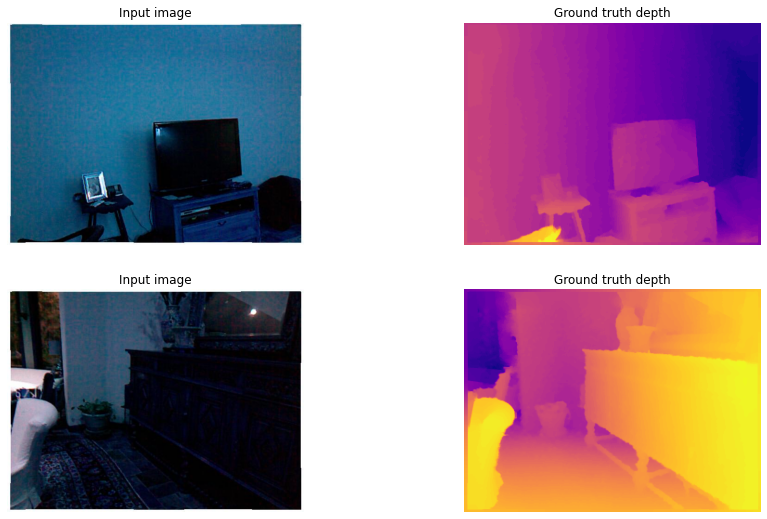

In [ ]:
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
  image = images[i]
  depth = depths[i].squeeze(-1)
  plt.subplot(221+i)
  plt.axis('off')
  plt.imshow(image)
  plt.title('Input image')
  plt.subplot(222+i)
  plt.axis('off')
  plt.imshow(depth,cmap=plt.get_cmap(cmap))
  plt.title('Ground truth depth')

#Model Creation

In [ ]:
# Model
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, concatenate, Concatenate, Input
from tensorflow.keras import Model

def upsampling(input_tensor, n_filters, concat_layer):
  '''
  Block of Decoder
  '''
  # Bilinear 2x upsampling layer
  x = UpSampling2D(size=(2,2), interpolation='bilinear')(input_tensor)
  # concatenation with encoder block 
  x = concatenate([x,concat_layer])
  # decreasing the depth filters by half
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = BatchNormalization()(x)
  return x

# Layer name of encoders to be concatenated
names = ['pool3_pool', 'pool2_pool', 'pool1','conv1/relu']
# Transfer learning approach without the classification head
encoder = DenseNet169(include_top=False, weights='imagenet', input_shape=(480,640,3))
for layer in encoder.layers:
  layer.trainable = False
inputs = encoder.input
x = encoder.output
# decoder blocks linked with corresponding encoder blocks
bneck = Conv2D(filters=1664, kernel_size=(1,1), padding='same')(x)
x = LeakyReLU(alpha=0.2)(bneck)
x = upsampling(bneck, 832, encoder.get_layer(names[0]).output)
x = LeakyReLU(alpha=0.2)(x)
x = upsampling(x, 416, encoder.get_layer(names[1]).output)
x = LeakyReLU(alpha=0.2)(x)
x = upsampling(x, 208, encoder.get_layer(names[2]).output)
x = LeakyReLU(alpha=0.2)(x)
x = upsampling(x, 104, encoder.get_layer(names[3]).output)
x = Conv2D(filters=1, activation='sigmoid', kernel_size=(3,3), padding='same')(x)

model = Model(inputs=inputs, outputs=x)
model.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 486, 646, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 240, 320, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

def loss_function(y_true, y_pred):

  #Cosine distance loss
  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
  
  # edge loss for sharp edges
  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
  
  # structural similarity loss
  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  # weightage
  w1, w2, w3 = 1.0, 1.0, 0.1
  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))



#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# save model frequently for later use.
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/Shareddrives/DeepLearning_VisionAnalytics/saved_models/depth_estimation/denseNet',
                                                save_best_only=True,
                                                verbose=1)
# Learning rate scheduler
def polynomial_decay(epoch):
  max_epochs = 10
  base_lr =  0.0001
  power = 1.0
  lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
  return lr

callbacks = [LearningRateScheduler(polynomial_decay, verbose=1), checkpoint]


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# loading Saved model

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/DeepLearning_VisionAnalytics/saved_models/depth_estimation/denseNet/', custom_objects={'loss_function':loss_function, 'accuracy_function' : accuracy_function})

# Training

In [ ]:
#model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
history = model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
10137/10137 [==============================] - ETA: 0s - loss: 0.1376 - accuracy_function: 0.7936
Epoch 1: val_loss improved from inf to 0.13232, saving model to /content/drive/Shareddrives/DeepLearning_VisionAnalytics/saved_models/depth_estimation/denseNet


10137/10137 [==============================] - 7032s 691ms/step - loss: 0.1376 - accuracy_function: 0.7936 - val_loss: 0.1323 - val_accuracy_function: 0.8047 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9e-05.
Epoch 2/5
 2602/10137 [======>.......................] - ETA: 1:17:19 - loss: 0.1309 - accuracy_function: 0.8042

# Test of depth estimation

In [ ]:
model.evaluate(test_generator)

40/40 [==============================] - 53s 754ms/step - loss: 0.1854 - accuracy_function: 0.7601


[0.18538084626197815, 0.7601100206375122]

In [ ]:
images, labels = next(iter(test_generator))
preds = model.predict(images)

1/1 [==============================] - 4s 4s/step


In [ ]:
preds.shape, images.shape

((16, 240, 320, 1), (16, 480, 640, 3))

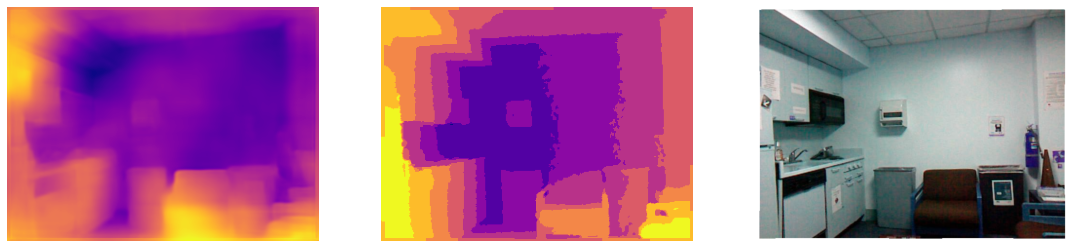

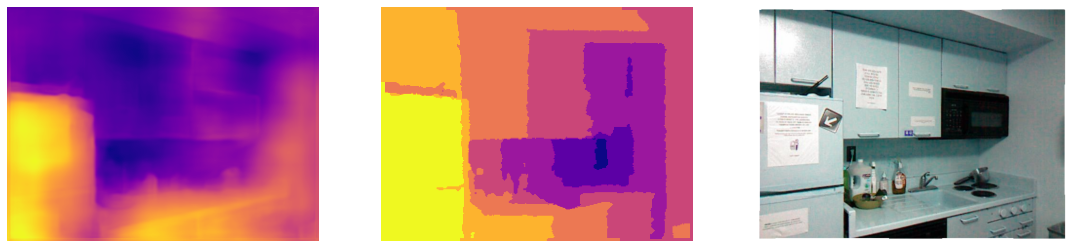

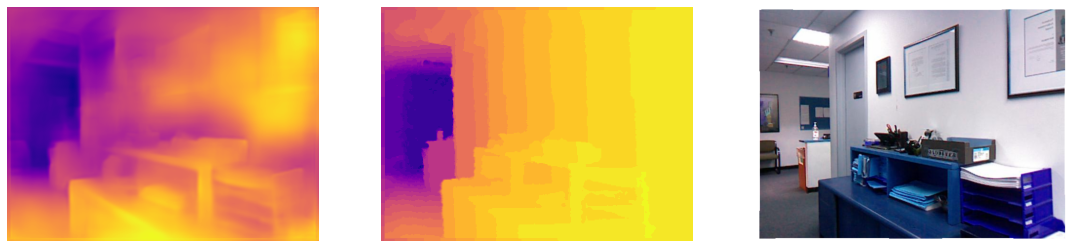

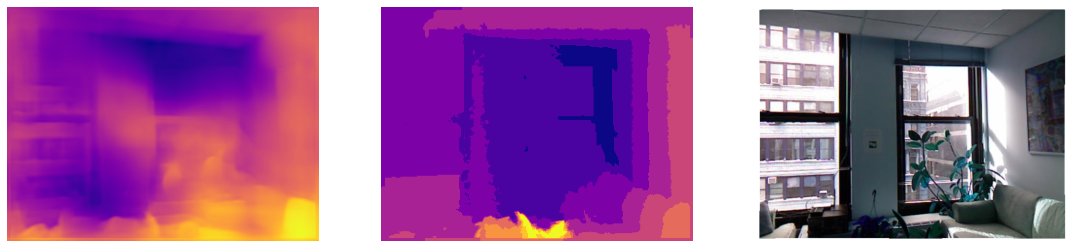

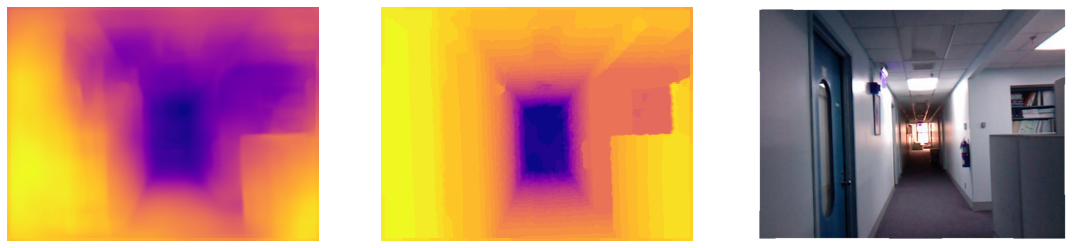

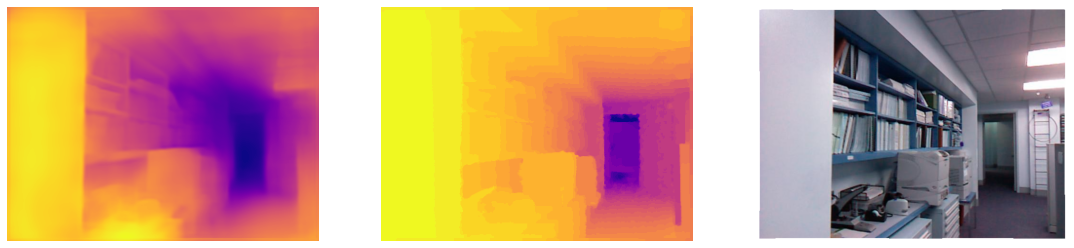

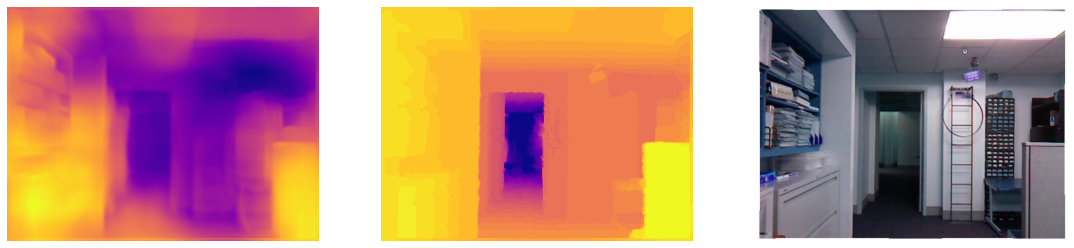

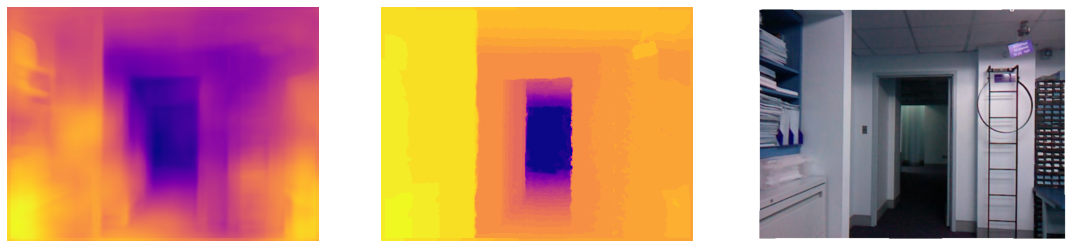

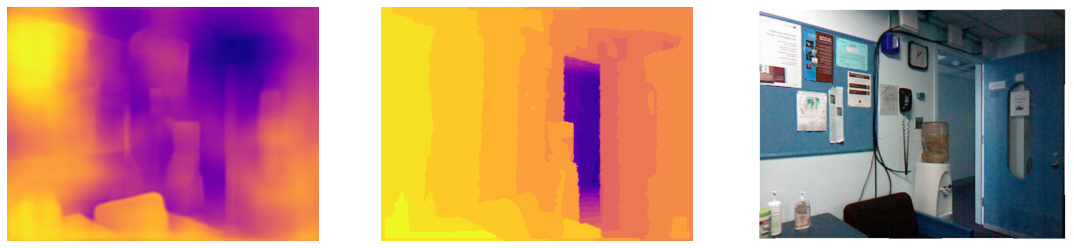

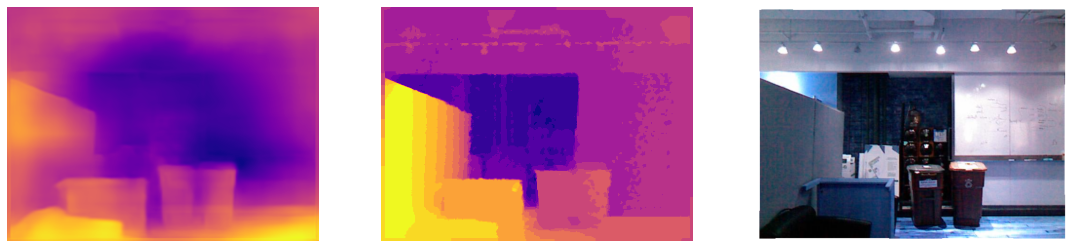

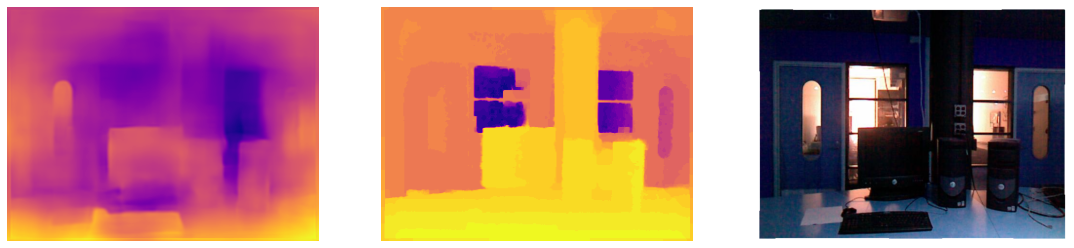

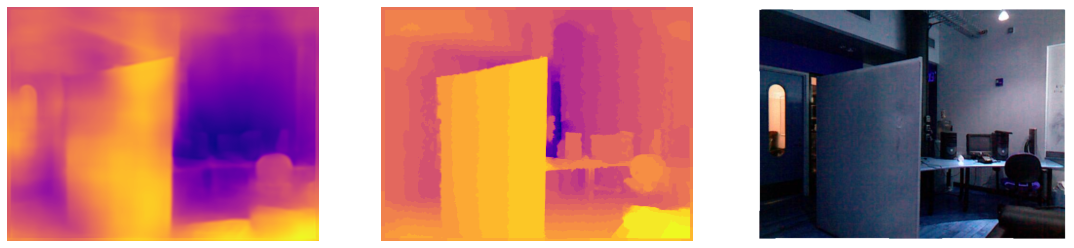

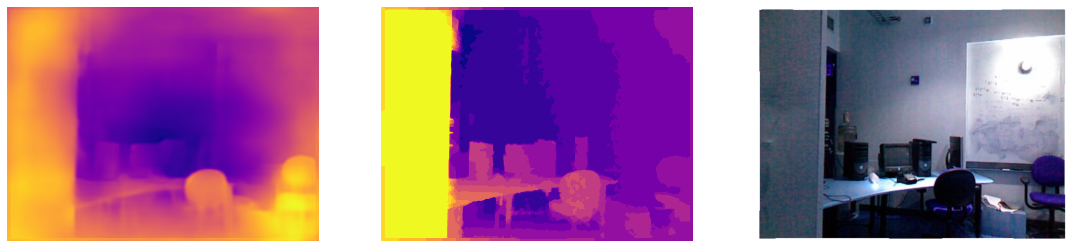

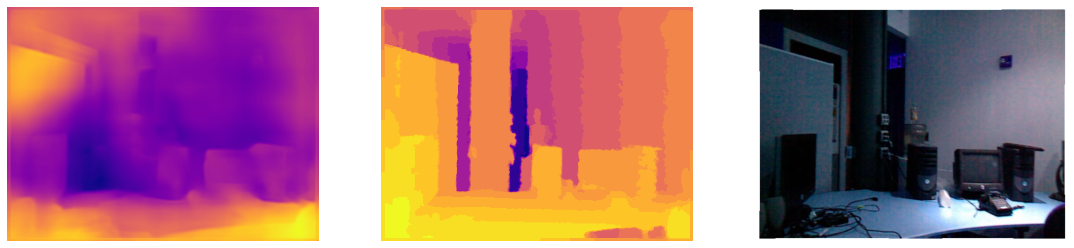

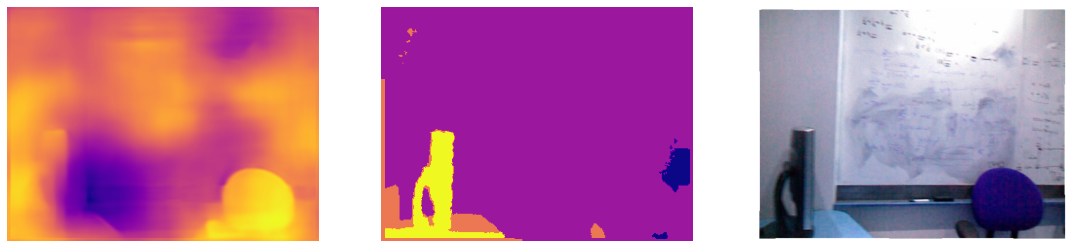

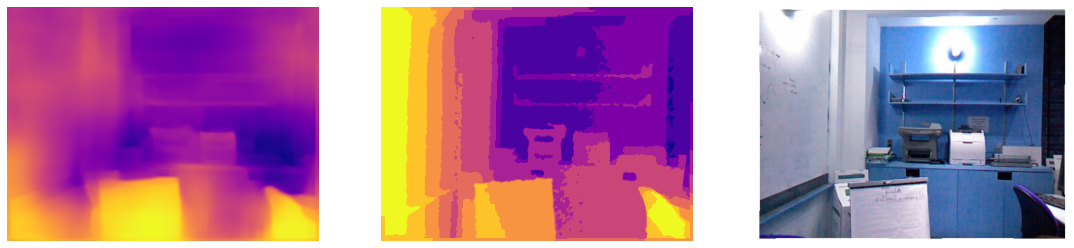

In [ ]:
cmap = "plasma_r"


for i in range(len(images)):
  plt.figure(figsize=(19,10))
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = images[i]
  plt.imshow(img1)

  plt.show()

# Generating Bokeh on Testset

In [ ]:
from skimage.transform import resize
import os
from io import BytesIO
import tarfile
import tempfile
import cv2
from six.moves import urllib
from copy import deepcopy
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IMG

In [ ]:
bokeh_GT = "/content/bokeh/"
bokeh_Original = "/content/original/"
outputdir = "/content/drive/Shareddrives/DeepLearning_VisionAnalytics/Depth_plus_Bokeh_Method/DepthModelOutputs_0.25_TH/"
DEPTH_THRESHOLD = 0.25

In [ ]:
def predict(IMAGE_NAME):
  orginal_img = np.array(Image.open(IMAGE_NAME))
  orginal_img_resized = np.expand_dims(resize(orginal_img, (480, 640, 3)), 0)
  preds = model.predict(orginal_img_resized)
  depth_map = preds[0].squeeze()

  img_resized_to_depth = resize(np.squeeze(orginal_img_resized), (depth_map.shape[0], depth_map.shape[1], 3))
  portrait_mask = deepcopy(img_resized_to_depth)
  portrait_mask[depth_map >= DEPTH_THRESHOLD] = 0
  portrait_mask[depth_map < DEPTH_THRESHOLD] = 255
  portrait_mask = portrait_mask.astype("uint8")

  mapping_resized = cv2.resize(portrait_mask, 
                              (orginal_img.shape[1],
                                orginal_img.shape[0]),
                              Image.ANTIALIAS)

  gray = cv2.cvtColor(mapping_resized, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (15,15),0)
  ret3, thresholded_img = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  mapping = cv2.cvtColor(thresholded_img, cv2.COLOR_GRAY2RGB)

  blurred_original_image = cv2.GaussianBlur(orginal_img,
                                            (251,251), 
                                            0)

  layered_image = np.where(mapping != (0,0,0), 
                          orginal_img, 
                          blurred_original_image)

  return layered_image

In [ ]:
if not os.path.exists(outputdir):
    os.mkdir(outputdir)
factor = 8 
for i in range(100):
    img = bokeh_Original + str(i) + ".jpg"
    # read img
    out_name = os.path.basename(img)
    output = predict(img)

    im_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    cv2.imwrite(os.path.join(outputdir, out_name), im_rgb)
    print('processing:',i+1, '/100, save img:',os.path.join(outputdir, out_name))
print('processed')

1/1 [==============================] - 0s 40ms/step
processing: 1 /100, save img: /content/drive/Shareddrives/DeepLearning_VisionAnalytics/Depth_plus_Bokeh_Method/DepthModelOutputs_0.25_TH/0.jpg
1/1 [==============================] - 0s 44ms/step
processing: 2 /100, save img: /content/drive/Shareddrives/DeepLearning_VisionAnalytics/Depth_plus_Bokeh_Method/DepthModelOutputs_0.25_TH/1.jpg
1/1 [==============================] - 0s 41ms/step
processing: 3 /100, save img: /content/drive/Shareddrives/DeepLearning_VisionAnalytics/Depth_plus_Bokeh_Method/DepthModelOutputs_0.25_TH/2.jpg
1/1 [==============================] - 0s 41ms/step
processing: 4 /100, save img: /content/drive/Shareddrives/DeepLearning_VisionAnalytics/Depth_plus_Bokeh_Method/DepthModelOutputs_0.25_TH/3.jpg
1/1 [==============================] - 0s 42ms/step
processing: 5 /100, save img: /content/drive/Shareddrives/DeepLearning_VisionAnalytics/Depth_plus_Bokeh_Method/DepthModelOutputs_0.25_TH/4.jpg
1/1 [====================

#Evaluation

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
values = []
for i in range(100):
  img1 = bokeh_GT + str(i) + ".jpg"
  img2 = outputdir + str(i) + ".jpg"

  ground_truth_bokeh = cv2.imread(img1)
  generated_bokeh = cv2.imread(img2)
  
  values.append(PSNR(ground_truth_bokeh, generated_bokeh))
values = np.array(values)
print(f"Avg PSNR value is {np.average(values)} dB")

Avg PSNR value is 29.10593104655784 dB


### SSIM

In [ ]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [ ]:
values = []
for i in range(100):
  img1 = bokeh_GT + str(i) + ".jpg"
  img2 = outputdir + str(i) + ".jpg"

  ground_truth_bokeh = cv2.imread(img1)
  generated_bokeh = cv2.imread(img2)
  
  values.append(calculate_ssim(ground_truth_bokeh, generated_bokeh))
values = np.array(values)
print(f"Avg SSIM value is {np.average(values)} dB")

Avg SSIM value is 0.7902923852580966 dB
